# <div align="center"> Assignment 2 </div>

###  <div align="center"> Sumeth Lokuliyana (s3904996) </div>
###  <div align="center"> Janak Datta Velagapudi (s3903576) </div>

## <div align="center"> Classify Images based on Cancerous cells or not  </div>







### * As for this section we will be predicting images of cancer cells if they are cancerous or not .

### Import required packages 

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import RMSprop ,Adadelta ,SGD ,Adamax
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import  ModelCheckpoint , EarlyStopping
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall, AUC 
from sklearn.metrics import confusion_matrix
from keras.applications import VGG16

### Reading the CSV file and the images into a DataFrame .

##### The images are first read using the cv2 read and then appends it to an array . Similarly we add the image path to the dataframe as well.

In [2]:
main_csv_file = "data_labels_mainData.csv"
extra_csv_file ="data_labels_extraData.csv"
df = pd.read_csv(main_csv_file)
extra_df = pd.read_csv(extra_csv_file)

# Read the images from the directory and convert them to arrays
image_dir = "patch_images"
image_arrays = []
image_path=[]
for image_name in df["ImageName"]:
    img_pth = image_dir + "/" + image_name
    image_path.append(img_pth)
    img = cv2.imread(os.path.join(image_dir, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_arrays.append(img)
image_arrays = np.array(image_arrays)

#Merge the image arrays with the CSV dataframe
df["image_data"] = list(image_arrays)
df["image_path"] = image_path
df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_data,image_path
0,22405,1,22405.png,fibroblast,0,0,"[[[242, 213, 237], [239, 209, 233], [235, 205,...",patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,"[[[221, 175, 211], [224, 175, 211], [233, 184,...",patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,"[[[247, 243, 247], [248, 242, 246], [247, 239,...",patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,"[[[243, 242, 242], [243, 241, 241], [243, 241,...",patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,"[[[189, 130, 189], [186, 126, 184], [187, 126,...",patch_images/22409.png
...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,"[[[171, 138, 180], [217, 186, 228], [252, 224,...",patch_images/1625.png
9892,1626,60,1626.png,epithelial,2,1,"[[[212, 173, 228], [185, 145, 207], [164, 124,...",patch_images/1626.png
9893,1627,60,1627.png,epithelial,2,1,"[[[175, 141, 193], [196, 168, 209], [214, 188,...",patch_images/1627.png
9894,1628,60,1628.png,epithelial,2,1,"[[[227, 202, 232], [176, 146, 193], [183, 146,...",patch_images/1628.png


### Splitting the data into `Train` and `Test` sets


##### Initially we create a df of features that has the cellTypeName , celltype ,  the image data, isCancerous and the image path .

In [3]:

df = df.drop("ImageName", axis=1)
df = df.drop("InstanceID",axis=1)
df = df.drop("patientID",axis=1)
X_train, X_test = train_test_split(df, train_size=0.8, random_state=42)
X_test, X_val = train_test_split(X_test, test_size=0.2, random_state=42)
display(df)
display(X_train.shape)
display(X_test.shape)
display(X_val.shape)

,cellTypeName,cellType,isCancerous,image_data,image_path
0,fibroblast,0,0,"[[[242, 213, 237], [239, 209, 233], [235, 205,...",patch_images/22405.png
1,fibroblast,0,0,"[[[221, 175, 211], [224, 175, 211], [233, 184,...",patch_images/22406.png
2,fibroblast,0,0,"[[[247, 243, 247], [248, 242, 246], [247, 239,...",patch_images/22407.png
3,fibroblast,0,0,"[[[243, 242, 242], [243, 241, 241], [243, 241,...",patch_images/22408.png
4,fibroblast,0,0,"[[[189, 130, 189], [186, 126, 184], [187, 126,...",patch_images/22409.png
...,...,...,...,...,...
9891,epithelial,2,1,"[[[171, 138, 180], [217, 186, 228], [252, 224,...",patch_images/1625.png
9892,epithelial,2,1,"[[[212, 173, 228], [185, 145, 207], [164, 124,...",patch_images/1626.png
9893,epithelial,2,1,"[[[175, 141, 193], [196, 168, 209], [214, 188,...",patch_images/1627.png
9894,epithelial,2,1,"[[[227, 202, 232], [176, 146, 193], [183, 146,...",patch_images/1628.png


(7916, 5)

(1584, 5)

(396, 5)

#### We will now check the distribution of `Cancerous` and `Non-Cancerous` cells 
##### From the graph below we can say that there are more `Non-cancerous` cells.

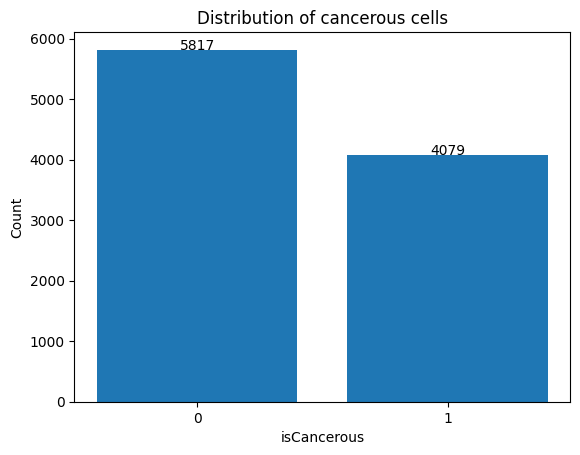

In [4]:
target_counts = df["isCancerous"].value_counts()
plt.bar([0,1], target_counts.values)
plt.xticks([0,1])
plt.title('Distribution of cancerous cells')
plt.xlabel('isCancerous')
plt.ylabel('Count')
for i, value in enumerate(target_counts.values):
    plt.text(i, value, str(value), ha='center')
plt.show()


We will plot a graph to figure out which type of cells are more prone to become cancerous

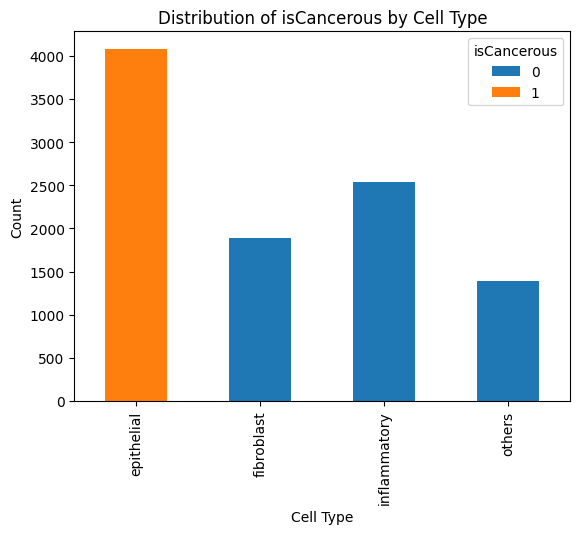

In [5]:
grouped = df.groupby(['isCancerous', 'cellTypeName'])['cellTypeName'].count().unstack('isCancerous')
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Distribution of isCancerous by Cell Type')
plt.show()


We will print out some random images to visualize

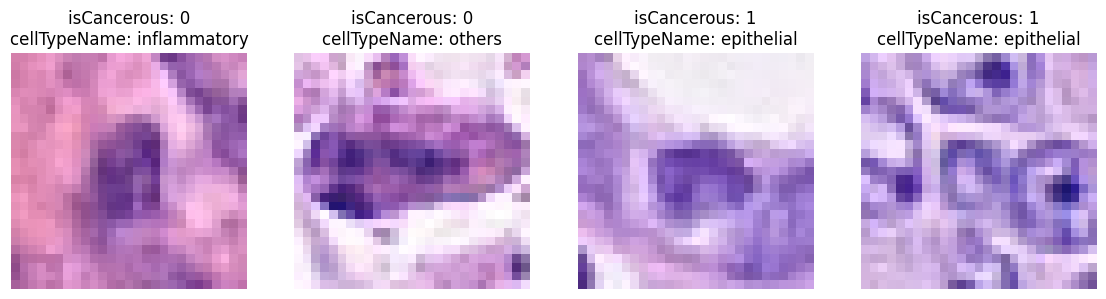

In [6]:
r_inx = np.random.choice(9896, 4)
rand_data = df.loc[r_inx,['image_path', 'isCancerous', 'cellTypeName']]

plt.figure(figsize=(14,4))
for i, (image_path, is_cancerous, cell_type) in enumerate(zip(rand_data['image_path'], rand_data['isCancerous'], rand_data['cellTypeName'])):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im)
    plt.title(f'isCancerous: {is_cancerous}\ncellTypeName: {cell_type}')
    plt.axis('off')
    
plt.show()


##  The Base Models

For the base model(s) well use just three layers , we will increment improvements on the best base model to gain a better accurcy and lower margin between the train and test data.
We will implement 
+ The `Flatten` layer - this will flatten the input image from a 3D shape (32x32x3) into a 1D array of 3072 elements.
+ The `Dense` layer It consists of 256 neurons which mean every neuron is connected every neuron in the previous layer.It uses sigmoid,softmax and relu as the activation functions.
+ The `Dense` layer This is the last output layer, which has 2 neurons and it determines if an input picture is cancerous or not. Seperate model uses the sigmoid.softmax,relu activation functions, which produces a value between 0 and 1 for each neuron, indicating the probability that the input picture belongs to that classification.

In [7]:
base_model_1 = Sequential([
    Flatten(input_shape=(27,27,3)),
    Dense(256, activation='softmax'),
    Dense(1 , activation='softmax')
])

base_model_2 = Sequential([
    Flatten(input_shape=(27,27,3)),
    Dense(256, activation='sigmoid'),
    Dense(1 , activation='sigmoid')
])

base_model_3 = Sequential([
    Flatten(input_shape=(27,27,3)),
    Dense(256, activation='relu'),
    Dense(1 , activation='relu')
])


In [8]:
base_model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [9]:
base_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2187)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               560128    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [10]:
base_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2187)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               560128    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


+ `optimizer='sgd'` -Stochastic gradient descent (SGD) is a popular optimization approach used for changing the neural network's weights and biases throughout the training period.
+ `loss=binary_crossentropy` - This is used beacuse the classification is between two classes (isCancerous or not)
+ `metrics=['accuracy']` - gives us the percentage of correctly predicted labels out of the total number of predictions made.

We then convert the integer values to string because the ImageDataGenerator takes in string values

In [11]:
base_model_1.compile(optimizer='sgd',loss=binary_crossentropy,metrics=['accuracy', Precision(), Recall(), AUC()])

base_model_2.compile(optimizer='sgd',loss=binary_crossentropy,metrics=['accuracy', Precision(), Recall(), AUC()])

base_model_3.compile(optimizer='sgd',loss=binary_crossentropy,metrics=['accuracy', Precision(), Recall(), AUC()])


X_train['isCancerous'] = X_train['isCancerous'].astype('str')
X_val['isCancerous'] = X_val['isCancerous'].astype('str')

X_train['cellType'] = X_train['cellType'].astype('str')
X_val['cellType'] = X_val['cellType'].astype('str')

X_test['isCancerous'] = X_test['isCancerous'].astype('str')
X_test['cellType'] = X_test['cellType'].astype('str')

## Setting up ImageDataGenerators 

+ The `image generators` will rescale(optional) the images pixel values by dividing them by 255
+ The `target_size` argument determines the size to which the photos will be downsized/upsized in this case we keep it the same
+ The `batch_size` parameter provides the number of images to include in each batch during training and validation
+ The `class_mode` parameter tells if  the labels are binary or not.

### Fitting the data given by the `ImageDataGenerators` to the base_models

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')


validation_generator = val_datagen.flow_from_dataframe(
        dataframe=X_val,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')   

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=X_test,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

base_1_history = base_model_1.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)
base_2_history = base_model_2.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)
base_3_history = base_model_3.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Found 7916 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Epoch 1/100
248/248 [==============================] - 4s 14ms/step - loss: 0.6864 - accuracy: 0.4154 - precision: 0.4154 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.6832 - val_accuracy: 0.4242 - val_precision: 0.4242 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/100
248/248 [==============================] - 3s 12ms/step - loss: 0.6779 - accuracy: 0.4154 - precision: 0.4154 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.6772 - val_accuracy: 0.4242 - val_precision: 0.4242 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/100
248/248 [==============================] - 3s 12ms/step - loss: 0.6732 - accuracy: 0.4154 - precision: 0.4154 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.6741 - val_accuracy: 0.4242 - val_precision: 0.4242 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/100
248/248 [=======================

## Graphs of Accuracy and Loss on Train and Validation data(base models)

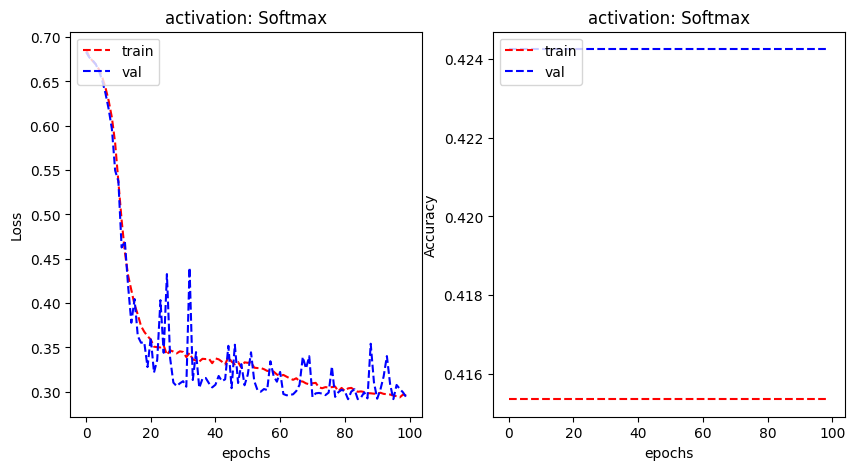

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(base_1_history.history['loss'], 'r--')
plt.plot(base_1_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.title("activation: Softmax")

plt.subplot(1,2,2)
plt.plot(base_1_history.history['accuracy'], 'r--')
plt.plot(base_1_history.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.title("activation: Softmax")
plt.show()

plt.show()

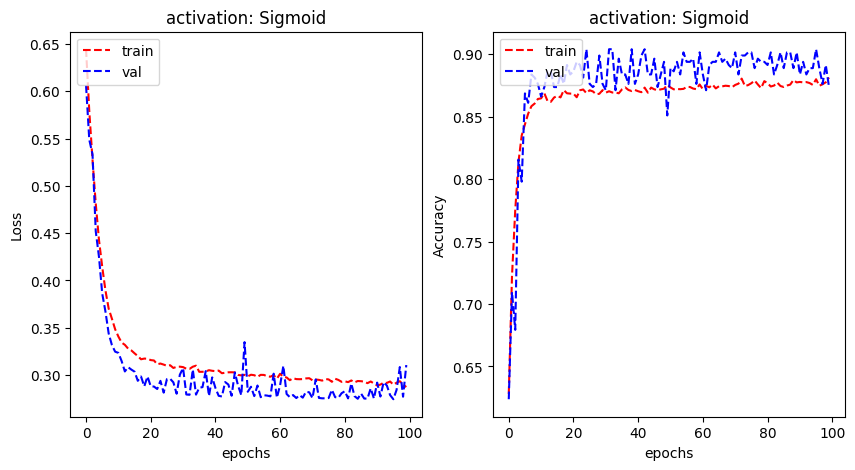

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(base_2_history.history['loss'], 'r--')
plt.plot(base_2_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.title("activation: Sigmoid")

plt.subplot(1,2,2)
plt.plot(base_2_history.history['accuracy'], 'r--')
plt.plot(base_2_history.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.title("activation: Sigmoid")
plt.show()

plt.show()

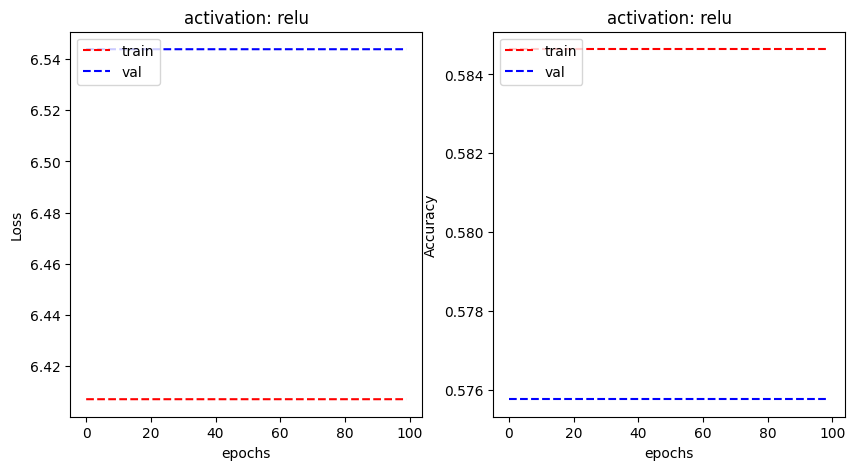

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(base_3_history.history['loss'], 'r--')
plt.plot(base_3_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.title("activation: relu")

plt.subplot(1,2,2)
plt.plot(base_3_history.history['accuracy'], 'r--')
plt.plot(base_3_history.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.title("activation: relu")
plt.show()

plt.show()

From the above graphs we say that the `sigmoid function` performed better in this case , because the difference  between the train and the test data is minimal 
and the loss decrease gradually . 
+ The validation data has a better accuracy and a lower loss than the training data , this is because the model is too simple to grasp the features of the training data hence it is under fitting. 

In [16]:
base_model_1.evaluate(test_generator)
base_model_2.evaluate(test_generator)
base_model_3.evaluate(test_generator)

1584/1584 [==============================] - 2s 1ms/step - loss: 6.0667 - accuracy: 0.6067 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.5000


[6.066731929779053, 0.6066918969154358, 0.0, 0.0, 0.5]

### Regularization of the model 

This is done inorder to reduce the overfitting of the data as the validation accuracy is less than that of the training accuracy . In this case well carry out regularization , to test if it has effect on the model . Because Regularization can sometimes reduce underfitting but is not always the case.

In [17]:
reg_lambda = 0.01
from keras.regularizers import l2

base_model_reg = Sequential([
    Flatten(input_shape=(27,27,3)),
    Dense(256,activation='sigmoid', kernel_regularizer=l2(reg_lambda)),
    Dense(1,activation='sigmoid')
])

base_model_reg.compile(optimizer=SGD(),loss=binary_crossentropy,metrics=['accuracy', Precision(), Recall(), AUC()])

history_reg = base_model_reg.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100
248/248 [==============================] - 4s 13ms/step - loss: 5.0106 - accuracy: 0.6237 - precision_3: 0.7269 - recall_3: 0.1505 - auc_3: 0.7175 - val_loss: 4.7599 - val_accuracy: 0.6641 - val_precision_3: 0.8302 - val_recall_3: 0.2619 - val_auc_3: 0.8689
Epoch 2/100
248/248 [==============================] - 3s 12ms/step - loss: 4.5389 - accuracy: 0.7250 - precision_3: 0.8474 - recall_3: 0.4121 - auc_3: 0.8437 - val_loss: 4.3214 - val_accuracy: 0.7045 - val_precision_3: 0.8806 - val_recall_3: 0.3512 - val_auc_3: 0.8892
Epoch 3/100
248/248 [==============================] - 3s 12ms/step - loss: 4.1208 - accuracy: 0.7730 - precision_3: 0.8418 - recall_3: 0.5584 - auc_3: 0.8755 - val_loss: 3.9177 - val_accuracy: 0.8030 - val_precision_3: 0.8750 - val_recall_3: 0.6250 - val_auc_3: 0.9065
Epoch 4/100
248/248 [==============================] - 3s 13ms/step - loss: 3.7469 - accuracy: 0.8076 - precision_3: 0.8490 - recall_3: 0.6530 - auc_3: 0.8942 - val_loss: 3.5599 - val_accura

## Graphs of Accuracy and Loss on Train and Validation data(regularized model)

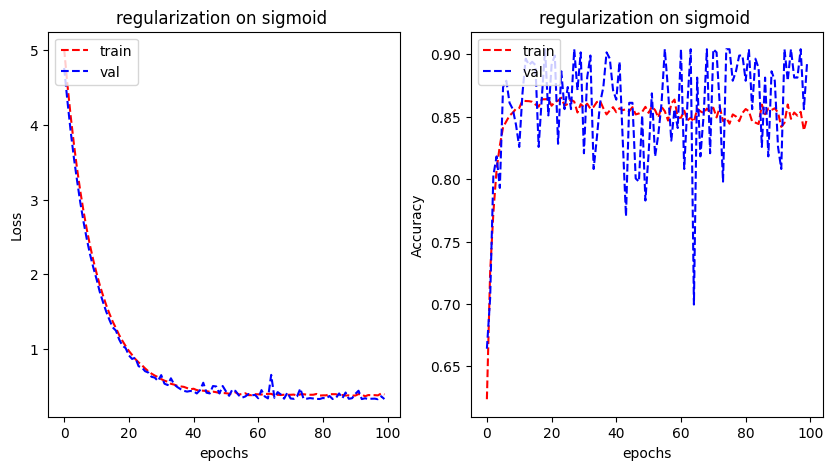

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.title("regularization on sigmoid ")

plt.subplot(1,2,2)
plt.plot(history_reg.history['accuracy'], 'r--')
plt.plot(history_reg.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.title("regularization on sigmoid ")
plt.show()

plt.show()

- We can see that the loss of both the train and validation data are similar , but the accuracy is not , even though they end up on a similar accuracy at the end of 100 epochs , the fluctuation of the accuracy have to be fixed , well try adding more layers . Regularization had a negative effect on the data set and didnt reduce the undefitting issue.

### To reduce underfitting even further we will be adding more layers 

+ We need to make the model more complex inorder to reduce underfitting .
+ This can be done by adding more layers and add `Dense` later on to prevent over fitting .
+ We dont add `Dropout` on this mdoel because it is not complex.


In [19]:
add_layers = Sequential([
    Flatten(input_shape=(27,27,3)),
    Dense(256, activation='relu'),
    Dense(128, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

add_layers.compile(optimizer=SGD(),loss=binary_crossentropy,metrics=['accuracy', Precision(), Recall(), AUC()])

history_add_lyr = add_layers.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100
248/248 [==============================] - 3s 12ms/step - loss: 0.6323 - accuracy: 0.6302 - precision_4: 0.7807 - recall_4: 0.1527 - auc_4: 0.7610 - val_loss: 0.5962 - val_accuracy: 0.6490 - val_precision_4: 0.8919 - val_recall_4: 0.1964 - val_auc_4: 0.8896
Epoch 2/100
248/248 [==============================] - 3s 11ms/step - loss: 0.5629 - accuracy: 0.7386 - precision_4: 0.8592 - recall_4: 0.4434 - auc_4: 0.8650 - val_loss: 0.5099 - val_accuracy: 0.8258 - val_precision_4: 0.8837 - val_recall_4: 0.6786 - val_auc_4: 0.9216
Epoch 3/100
248/248 [==============================] - 3s 12ms/step - loss: 0.4826 - accuracy: 0.8080 - precision_4: 0.8311 - recall_4: 0.6749 - auc_4: 0.8950 - val_loss: 0.4223 - val_accuracy: 0.8737 - val_precision_4: 0.8554 - val_recall_4: 0.8452 - val_auc_4: 0.9364
Epoch 4/100
248/248 [==============================] - 3s 13ms/step - loss: 0.4165 - accuracy: 0.8356 - precision_4: 0.8324 - recall_4: 0.7567 - auc_4: 0.9098 - val_loss: 0.3586 - val_accura

### Graph of loss and accuracy  for the model with more layers

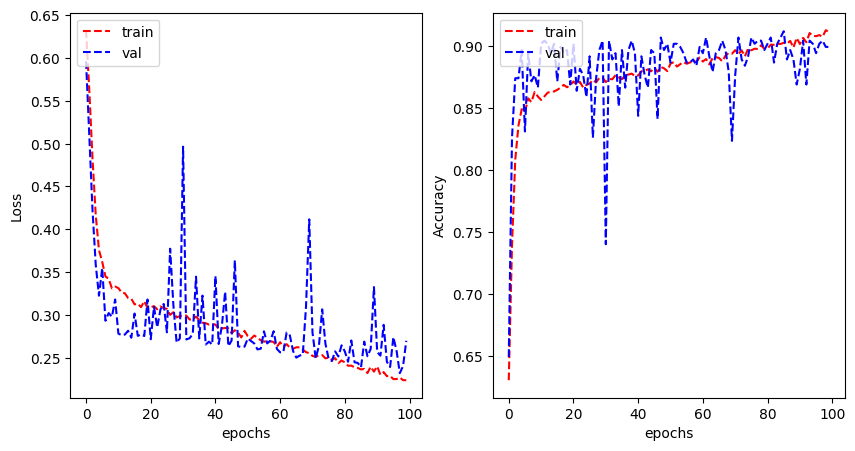

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_add_lyr.history['loss'], 'r--')
plt.plot(history_add_lyr.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_add_lyr.history['accuracy'], 'r--')
plt.plot(history_add_lyr.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Evaluating  the models on the test data 
+ we evaluate the model with regularization and the one with more layers.

In [21]:
base_model_reg.evaluate(test_generator)
add_layers.evaluate(test_generator)

1584/1584 [==============================] - 2s 1ms/step - loss: 0.2824 - accuracy: 0.8864 - precision_4: 0.8879 - recall_4: 0.8138 - auc_4: 0.9531


[0.2823978066444397,
 0.8863636255264282,
 0.8879159092903137,
 0.8138041496276855,
 0.9530836343765259]

### Visualizing the prediction of the model(s) on Test data
+ The model with more layers
+ The regularized model
+ The base model

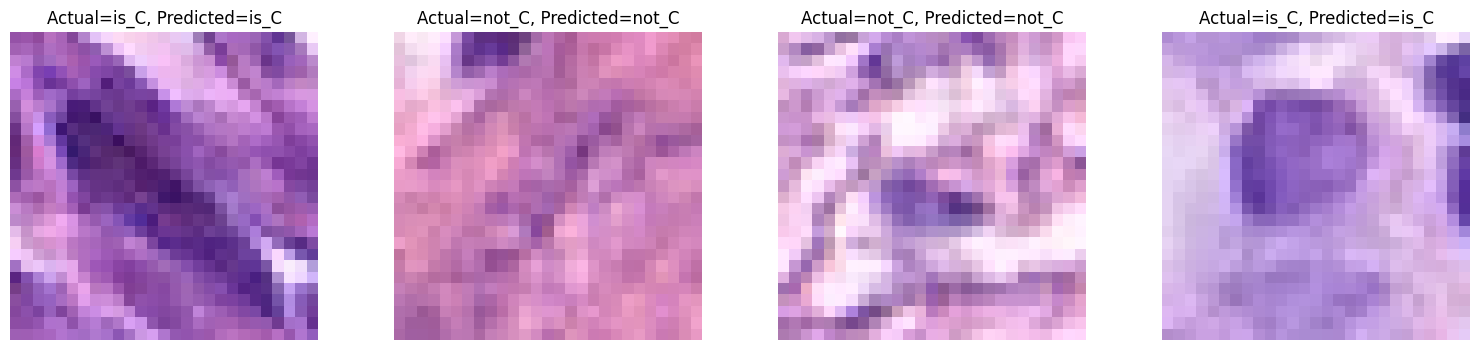

In [22]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = add_layers.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


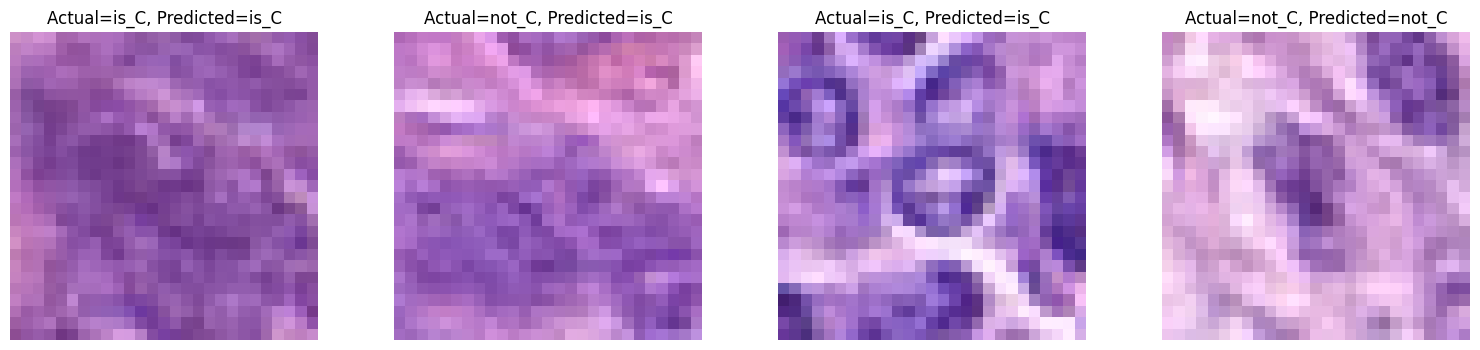

In [23]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = base_model_reg.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


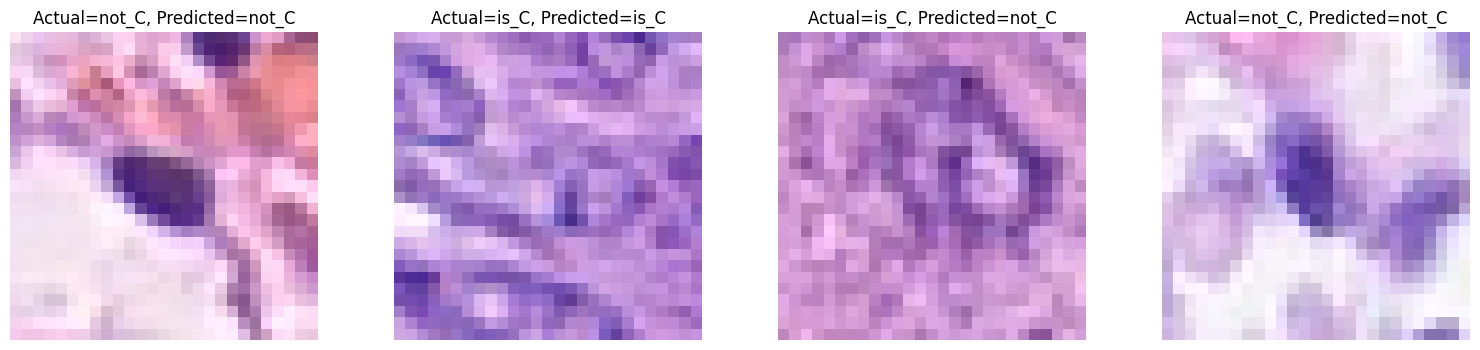

In [24]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred = base_model_2.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


### Adding more layers to the model (Advanced Model)

+ We add more `Conv2D` layers and `Dense` layers , we will increase `Dropout` inorder to prevent the model from overfitting .
+ We use `Early Stopping` and `Model Checkpoint` in order to obtain the best model out of the 60 epoches running.

In [25]:
adv_model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=(27, 27, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.15),
    Conv2D(128, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),
    Conv2D(256, kernel_size=(3, 3), activation="relu"),
    Conv2D(512, kernel_size=(3, 3), activation="relu"),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])



early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath ='adv.model', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=False,verbose=1)

adv_model.compile(optimizer=SGD(), loss=binary_crossentropy, metrics=['accuracy', Precision(), Recall(), AUC()])


history_adv = adv_model.fit(train_generator, validation_data = validation_generator, epochs=60, verbose=1,callbacks=[model_checkpoint,early_stopping])

Epoch 1/60
248/248 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5848 - precision_5: 1.0000 - recall_5: 3.0414e-04 - auc_5: 0.5280
Epoch 1: val_accuracy improved from -inf to 0.57576, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 17s 67ms/step - loss: 0.6799 - accuracy: 0.5848 - precision_5: 1.0000 - recall_5: 3.0414e-04 - auc_5: 0.5280 - val_loss: 0.6787 - val_accuracy: 0.5758 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.7090
Epoch 2/60
248/248 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.5846 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.6286
Epoch 2: val_accuracy did not improve from 0.57576
248/248 [==============================] - 14s 58ms/step - loss: 0.6746 - accuracy: 0.5846 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.6286 - val_loss: 0.6758 - val_accuracy: 0.5758 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.7942
Epoch 3/60
248/248 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.5846 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.7023
Epoch 3: val_accuracy did not improve from 0.57576
248/248 [=====================

INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 61ms/step - loss: 0.6581 - accuracy: 0.5846 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.7212 - val_loss: 0.6425 - val_accuracy: 0.5833 - val_precision_5: 1.0000 - val_recall_5: 0.0179 - val_auc_5: 0.8806
Epoch 5/60
248/248 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.6470 - precision_5: 0.7826 - recall_5: 0.2080 - auc_5: 0.7741
Epoch 5: val_accuracy improved from 0.58333 to 0.65909, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 61ms/step - loss: 0.6135 - accuracy: 0.6470 - precision_5: 0.7826 - recall_5: 0.2080 - auc_5: 0.7741 - val_loss: 0.6500 - val_accuracy: 0.6591 - val_precision_5: 0.5548 - val_recall_5: 0.9940 - val_auc_5: 0.8645
Epoch 6/60
248/248 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7305 - precision_5: 0.7101 - recall_5: 0.5937 - auc_5: 0.7948
Epoch 6: val_accuracy improved from 0.65909 to 0.76515, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.5544 - accuracy: 0.7305 - precision_5: 0.7101 - recall_5: 0.5937 - auc_5: 0.7948 - val_loss: 0.4733 - val_accuracy: 0.7652 - val_precision_5: 0.9032 - val_recall_5: 0.5000 - val_auc_5: 0.9215
Epoch 7/60
248/248 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.7808 - precision_5: 0.7525 - recall_5: 0.7038 - auc_5: 0.8520
Epoch 7: val_accuracy improved from 0.76515 to 0.76768, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.4834 - accuracy: 0.7808 - precision_5: 0.7525 - recall_5: 0.7038 - auc_5: 0.8520 - val_loss: 0.4719 - val_accuracy: 0.7677 - val_precision_5: 0.9222 - val_recall_5: 0.4940 - val_auc_5: 0.9304
Epoch 8/60
248/248 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8005 - precision_5: 0.7637 - recall_5: 0.7527 - auc_5: 0.8746
Epoch 8: val_accuracy did not improve from 0.76768
248/248 [==============================] - 14s 57ms/step - loss: 0.4457 - accuracy: 0.8005 - precision_5: 0.7637 - recall_5: 0.7527 - auc_5: 0.8746 - val_loss: 0.7467 - val_accuracy: 0.5354 - val_precision_5: 0.4773 - val_recall_5: 1.0000 - val_auc_5: 0.8595
Epoch 9/60
248/248 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8135 - precision_5: 0.7812 - recall_5: 0.7655 - auc_5: 0.8913
Epoch 9: val_accuracy did not improve from 0.76768
248/248 [==============================] - 14s 57ms/step - loss: 0.4146 - 

INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.3864 - accuracy: 0.8332 - precision_5: 0.8075 - recall_5: 0.7859 - auc_5: 0.9054 - val_loss: 0.3282 - val_accuracy: 0.8788 - val_precision_5: 0.8093 - val_recall_5: 0.9345 - val_auc_5: 0.9549
Epoch 11/60
248/248 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8393 - precision_5: 0.8125 - recall_5: 0.7971 - auc_5: 0.9131
Epoch 11: val_accuracy improved from 0.87879 to 0.88889, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 16s 65ms/step - loss: 0.3708 - accuracy: 0.8393 - precision_5: 0.8125 - recall_5: 0.7971 - auc_5: 0.9131 - val_loss: 0.3026 - val_accuracy: 0.8889 - val_precision_5: 0.8370 - val_recall_5: 0.9167 - val_auc_5: 0.9582
Epoch 12/60
248/248 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8475 - precision_5: 0.8197 - recall_5: 0.8114 - auc_5: 0.9215
Epoch 12: val_accuracy did not improve from 0.88889
248/248 [==============================] - 15s 60ms/step - loss: 0.3527 - accuracy: 0.8475 - precision_5: 0.8197 - recall_5: 0.8114 - auc_5: 0.9215 - val_loss: 0.3279 - val_accuracy: 0.8460 - val_precision_5: 0.9280 - val_recall_5: 0.6905 - val_auc_5: 0.9526
Epoch 13/60
248/248 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.8543 - precision_5: 0.8298 - recall_5: 0.8169 - auc_5: 0.9271
Epoch 13: val_accuracy improved from 0.88889 to 0.90404, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.3399 - accuracy: 0.8543 - precision_5: 0.8298 - recall_5: 0.8169 - auc_5: 0.9271 - val_loss: 0.2704 - val_accuracy: 0.9040 - val_precision_5: 0.8869 - val_recall_5: 0.8869 - val_auc_5: 0.9619
Epoch 14/60
248/248 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8549 - precision_5: 0.8339 - recall_5: 0.8123 - auc_5: 0.9288
Epoch 14: val_accuracy did not improve from 0.90404
248/248 [==============================] - 14s 58ms/step - loss: 0.3349 - accuracy: 0.8549 - precision_5: 0.8339 - recall_5: 0.8123 - auc_5: 0.9288 - val_loss: 0.4109 - val_accuracy: 0.8056 - val_precision_5: 0.6920 - val_recall_5: 0.9762 - val_auc_5: 0.9673
Epoch 15/60
248/248 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8631 - precision_5: 0.8395 - recall_5: 0.8288 - auc_5: 0.9337
Epoch 15: val_accuracy did not improve from 0.90404
248/248 [==============================] - 14s 58ms/step - loss: 0.324

INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.3142 - accuracy: 0.8658 - precision_5: 0.8507 - recall_5: 0.8212 - auc_5: 0.9373 - val_loss: 0.2358 - val_accuracy: 0.9066 - val_precision_5: 0.8830 - val_recall_5: 0.8988 - val_auc_5: 0.9724
Epoch 20/60
248/248 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8660 - precision_5: 0.8505 - recall_5: 0.8218 - auc_5: 0.9386
Epoch 20: val_accuracy did not improve from 0.90657
248/248 [==============================] - 14s 57ms/step - loss: 0.3117 - accuracy: 0.8660 - precision_5: 0.8505 - recall_5: 0.8218 - auc_5: 0.9386 - val_loss: 0.2778 - val_accuracy: 0.8990 - val_precision_5: 0.8478 - val_recall_5: 0.9286 - val_auc_5: 0.9719
Epoch 21/60
248/248 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8718 - precision_5: 0.8575 - recall_5: 0.8291 - auc_5: 0.9414
Epoch 21: val_accuracy did not improve from 0.90657
248/248 [==============================] - 14s 58ms/step - loss: 0.303

INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 61ms/step - loss: 0.2892 - accuracy: 0.8838 - precision_5: 0.8726 - recall_5: 0.8434 - auc_5: 0.9467 - val_loss: 0.2384 - val_accuracy: 0.9091 - val_precision_5: 0.8667 - val_recall_5: 0.9286 - val_auc_5: 0.9727
Epoch 25/60
248/248 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8800 - precision_5: 0.8621 - recall_5: 0.8464 - auc_5: 0.9488
Epoch 25: val_accuracy did not improve from 0.90909
248/248 [==============================] - 15s 59ms/step - loss: 0.2850 - accuracy: 0.8800 - precision_5: 0.8621 - recall_5: 0.8464 - auc_5: 0.9488 - val_loss: 0.4012 - val_accuracy: 0.8005 - val_precision_5: 0.6846 - val_recall_5: 0.9821 - val_auc_5: 0.9760
Epoch 26/60
248/248 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.8804 - precision_5: 0.8643 - recall_5: 0.8446 - auc_5: 0.9475
Epoch 26: val_accuracy did not improve from 0.90909
248/248 [==============================] - 15s 59ms/step - loss: 0.288

INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 16s 65ms/step - loss: 0.2733 - accuracy: 0.8888 - precision_5: 0.8765 - recall_5: 0.8525 - auc_5: 0.9524 - val_loss: 0.2248 - val_accuracy: 0.9217 - val_precision_5: 0.8785 - val_recall_5: 0.9464 - val_auc_5: 0.9775
Epoch 30/60
248/248 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.8869 - precision_5: 0.8761 - recall_5: 0.8476 - auc_5: 0.9538
Epoch 30: val_accuracy improved from 0.92172 to 0.92677, saving model to adv.model


INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.2700 - accuracy: 0.8869 - precision_5: 0.8761 - recall_5: 0.8476 - auc_5: 0.9538 - val_loss: 0.2173 - val_accuracy: 0.9268 - val_precision_5: 0.8883 - val_recall_5: 0.9464 - val_auc_5: 0.9770
Epoch 31/60
248/248 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.8888 - precision_5: 0.8758 - recall_5: 0.8534 - auc_5: 0.9539
Epoch 31: val_accuracy did not improve from 0.92677
248/248 [==============================] - 14s 58ms/step - loss: 0.2690 - accuracy: 0.8888 - precision_5: 0.8758 - recall_5: 0.8534 - auc_5: 0.9539 - val_loss: 0.2093 - val_accuracy: 0.9141 - val_precision_5: 0.9136 - val_recall_5: 0.8810 - val_auc_5: 0.9750
Epoch 32/60
248/248 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8867 - precision_5: 0.8763 - recall_5: 0.8467 - auc_5: 0.9544
Epoch 32: val_accuracy did not improve from 0.92677
248/248 [==============================] - 14s 58ms/step - loss: 0.268

INFO:tensorflow:Assets written to: adv.model\assets


INFO:tensorflow:Assets written to: adv.model\assets


248/248 [==============================] - 15s 62ms/step - loss: 0.2674 - accuracy: 0.8905 - precision_5: 0.8758 - recall_5: 0.8580 - auc_5: 0.9548 - val_loss: 0.2024 - val_accuracy: 0.9318 - val_precision_5: 0.9172 - val_recall_5: 0.9226 - val_auc_5: 0.9774
Epoch 34/60
248/248 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8897 - precision_5: 0.8770 - recall_5: 0.8543 - auc_5: 0.9558
Epoch 34: val_accuracy did not improve from 0.93182
248/248 [==============================] - 14s 58ms/step - loss: 0.2648 - accuracy: 0.8897 - precision_5: 0.8770 - recall_5: 0.8543 - auc_5: 0.9558 - val_loss: 0.2454 - val_accuracy: 0.8889 - val_precision_5: 0.8163 - val_recall_5: 0.9524 - val_auc_5: 0.9777
Epoch 35/60
248/248 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.8888 - precision_5: 0.8751 - recall_5: 0.8543 - auc_5: 0.9550
Epoch 35: val_accuracy did not improve from 0.93182
248/248 [==============================] - 14s 58ms/step - loss: 0.266

## Graph for loss and accuracy for the `Advanced model`

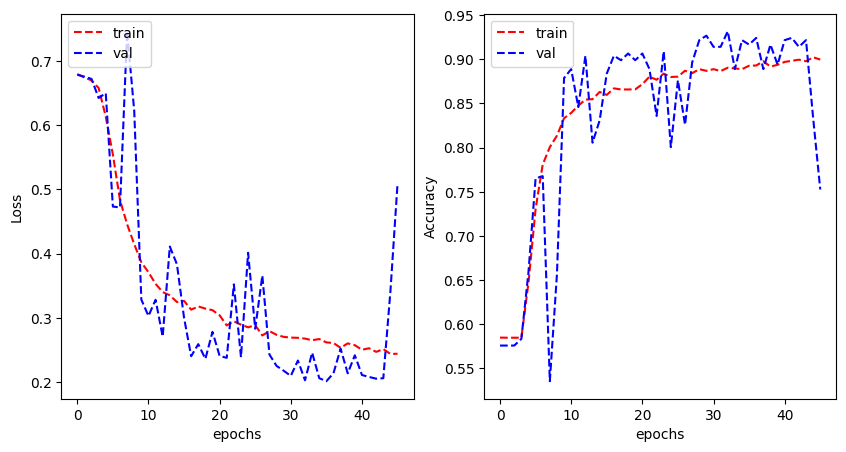

In [26]:
adv_model = load_model('adv.model')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_adv.history['loss'], 'r--')
plt.plot(history_adv.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_adv.history['accuracy'], 'r--')
plt.plot(history_adv.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

+ As we can see the under fitting is reduced by a certain amount but not completely . It was comparatively better than to how it was. The issue is that the validation accuracy and the loss in not constant it has too much fluctuation .

In [27]:
adv_model.evaluate(test_generator)

1584/1584 [==============================] - 5s 3ms/step - loss: 0.2566 - accuracy: 0.9040 - precision_5: 0.8663 - recall_5: 0.8941 - auc_5: 0.9597


[0.2565663158893585,
 0.9040403962135315,
 0.8662519454956055,
 0.8940609693527222,
 0.9596552848815918]

## Visualising predictions using the `Advanced model` on the Test Data

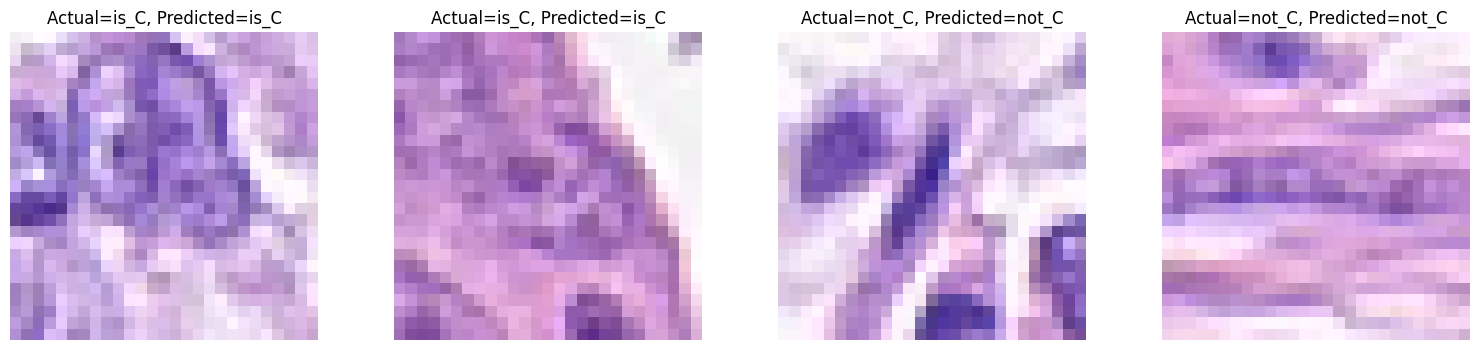

In [28]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_pred =adv_model.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


##  Table of the evaluation metrics used 

In [33]:
test_loss_adv, test_accuracy_adv, test_precision_adv, test_recall_adv, test_auc_adv = adv_model.evaluate(test_generator)

test_loss_addL, test_accuracy_addL, test_precision_addL, test_recall_addL, test_auc_addL = add_layers.evaluate(test_generator)
test_loss_reg, test_accuracy_reg, test_precision_reg, test_recall_reg, test_auc_reg = base_model_reg.evaluate(test_generator)


y_pred_adv = adv_model.predict(test_generator)

y_true = test_generator.classes

from tabulate import tabulate

metrics = ["test_loss", "test_accuracy", "test_precision", "test_recall", "test_auc"]
models = ["adv", "addL", "reg"]

data = [
    [test_loss_adv, test_accuracy_adv, test_precision_adv, test_recall_adv, test_auc_adv],
    [test_loss_addL, test_accuracy_addL, test_precision_addL, test_recall_addL, test_auc_addL],
    [test_loss_reg, test_accuracy_reg, test_precision_reg, test_recall_reg, test_auc_reg]
]

table = tabulate(data, headers=metrics, showindex=models, tablefmt="grid")

print(table)


1584/1584 [==============================] - 5s 3ms/step
+------+-------------+-----------------+------------------+---------------+------------+
|      |   test_loss |   test_accuracy |   test_precision |   test_recall |   test_auc |
+======+=============+=================+==================+===============+============+
| adv  |    0.256566 |        0.90404  |         0.866252 |      0.894061 |   0.959655 |
+------+-------------+-----------------+------------------+---------------+------------+
| addL |    0.282398 |        0.886364 |         0.887916 |      0.813804 |   0.953084 |
+------+-------------+-----------------+------------------+---------------+------------+
| reg  |    0.355687 |        0.876894 |         0.838608 |      0.850722 |   0.937334 |
+------+-------------+-----------------+------------------+---------------+------------+


## Alternate Base Model (using VGG16 ) (further Investigation ) - Possible improvements 

In [34]:
from keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### We resize the target_size

This is because VGG16 uses a minimum size of 32x32 .

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

alt_train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')


alt_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=X_val,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')   

batch_size = 1

alt_test_generator = test_datagen.flow_from_dataframe(
        dataframe=X_test,
        directory='./',
        x_col="image_path",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')

Found 7916 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.


In [36]:
history_alt = model.fit(alt_train_generator, validation_data = alt_validation_generator, epochs=60, verbose=1)

Epoch 1/60
248/248 [==============================] - 24s 93ms/step - loss: 0.4629 - accuracy: 0.7756 - val_loss: 0.3807 - val_accuracy: 0.8308
Epoch 2/60
248/248 [==============================] - 23s 93ms/step - loss: 0.3983 - accuracy: 0.8199 - val_loss: 0.3718 - val_accuracy: 0.8308
Epoch 3/60
248/248 [==============================] - 23s 91ms/step - loss: 0.3753 - accuracy: 0.8306 - val_loss: 0.3401 - val_accuracy: 0.8687
Epoch 4/60
248/248 [==============================] - 23s 93ms/step - loss: 0.3677 - accuracy: 0.8343 - val_loss: 0.3307 - val_accuracy: 0.8712
Epoch 5/60
248/248 [==============================] - 21s 83ms/step - loss: 0.3644 - accuracy: 0.8358 - val_loss: 0.3371 - val_accuracy: 0.8712
Epoch 6/60
248/248 [==============================] - 22s 89ms/step - loss: 0.3539 - accuracy: 0.8444 - val_loss: 0.3235 - val_accuracy: 0.8712
Epoch 7/60
248/248 [==============================] - 22s 87ms/step - loss: 0.3527 - accuracy: 0.8435 - val_loss: 0.3122 - val_accuracy:

In [37]:
model.evaluate(alt_test_generator)

1584/1584 [==============================] - 15s 9ms/step - loss: 0.3556 - accuracy: 0.8662


[0.3556390702724457, 0.8661616444587708]

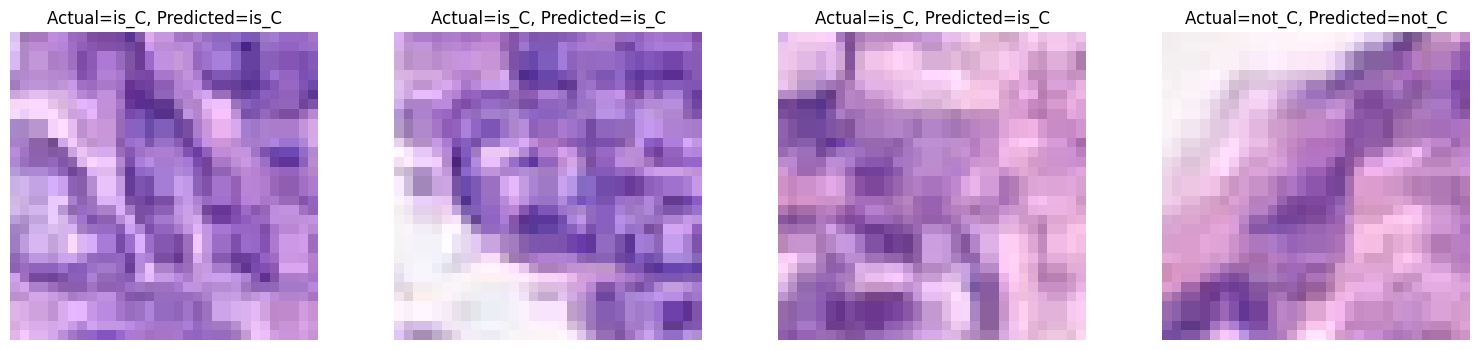

In [38]:
label_names = {0: 'not_C', 1: 'is_C'}
plt.figure(figsize=(19,4))
batches = 0
for x,y in alt_test_generator:
    batches = batches + 1
    y_pred =model.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches <= 4:
        plt.subplot(1,4,batches)
        plt.imshow(x)
        plt.title("Actual={}, Predicted={}".format(label_names[int(y[0])], label_names[int(np.round(y_pred[0][0]))]))
    else:
        break
    plt.axis('off')
plt.show()


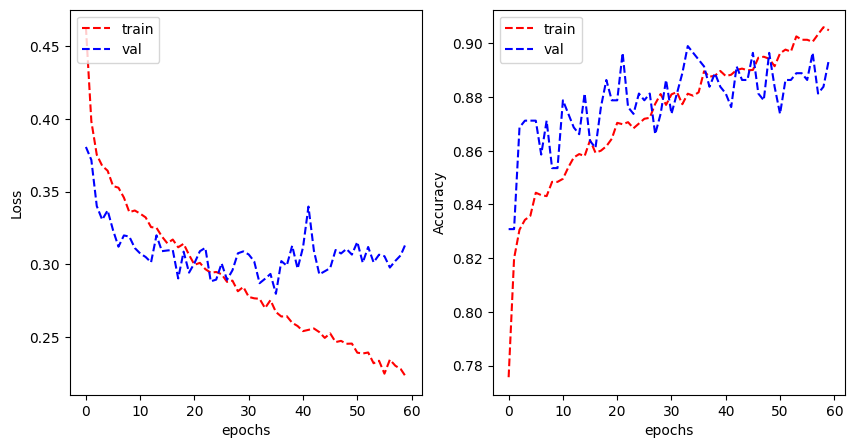

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_alt.history['loss'], 'r--')
plt.plot(history_alt.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_alt.history['accuracy'], 'r--')
plt.plot(history_alt.history['val_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

# References

+ https://www.kaggle.com/getting-started/264725
+ https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/ 
+ https://pypi.org/project/tabulate/
+ Week 9 labs and Q & A 